# Engineering Notebook
This is where I validate my feats of engineering via benchmarks and unit tests, so that several months later when I look back at the code and question certain decisions I can remind myself of why I made those decisions :)
The idea is for each cell to be self-contained and thus runnable independent of all other cells. Only requirement is run the cell below first for setup.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import timeit

# Benchmarking function
def benchmark(func, label, n = 100):
    time = timeit.timeit(func, number=n)
    print(f"{label}: {time:.5f} seconds")


# Decision to use multi-index with redundant levels vs columns
Representing redundant levels, such as experiment parameters, in multiindex instead of columns is at least 3x-5x faster for querying operations and marginally faster for groupby.

In [ ]:
import pandas as pd
import numpy as np

# Generate sample data
np.random.seed(42)
n = 100000  # Number of rows
levels1 = np.random.choice(['A', 'B', 'C', 'D'], size=n)
levels2 = np.random.choice(['X', 'Y', 'Z'], size=n)
levels3 = np.random.choice(['1'], size = n)
levels4 = levels3
values = np.random.randn(n)
data = {'level1': levels1, 'level2': levels2, 'level3': levels3, 'level4': levels4,'value': values}

# Create MultiIndex DataFrame
df_multi = pd.DataFrame(data)
df_multi.set_index(['level1', 'level2', 'level3', 'level4'], inplace=True)
df_multi.sort_index(inplace = True)

# Create Column-Based DataFrame
df_columns = pd.DataFrame(data)
df_columns.set_index(['level1', 'level2'], inplace=True)
df_columns.sort_index(inplace = True)

# Define query functions
def query_multi():
    x = df_multi.loc[('A', 'X', '1', '1')]
    return x[x['value'] > 0]

def query_columns():
    x = df_columns.loc[('A', 'X')]
    x = x[(x['level3'] == '1') & (x['level4'] == '1')]
    return x[x['value'] > 0]

# Benchmark operations
print("Benchmarking Pandas vs Polars DataFrame operations with MultiIndex:")

# Filtering
benchmark(query_multi, "Pandas Multi-index Filtering")
benchmark(query_columns, "Pandas Columns Filtering")

# Aggregation
benchmark(lambda: df_multi.groupby(['level1', 'level2', 'level3', 'level4'])['value'].mean(), "Pandas Multi-index GroupBy Mean")
benchmark(lambda: df_columns.groupby(['level1', 'level2', 'level3', 'level4'])['value'].mean(), "Pandas Columns GroupBy Mean")

# Sorting
benchmark(lambda: df_multi.sort_values('value'), "Pandas Multi-index Sorting")
benchmark(lambda: df_columns.sort_values('value'), "Pandas Columns Sorting")

# Join
df_multi2 = df_multi.copy()
df_columns2 = df_columns.copy()
df_multi2.rename(columns={'value': 'join_value'}, inplace=True)
df_columns2.rename(columns={'value': 'join_value'}, inplace=True)

benchmark(lambda: df_multi.merge(df_multi2, left_on='value', right_on='join_value'), "Pandas Multi-index Join")
benchmark(lambda: df_columns.merge(df_columns2, left_on='value', right_on='join_value'), "Pandas Columns Join")

Benchmarking Pandas vs Polars DataFrame operations with MultiIndex:
Pandas Multi-index Filtering: 0.04285 seconds
Pandas Columns Filtering: 0.10074 seconds


# Decision to use polars over pandas for huge dataframes

In [3]:
import pandas as pd
import polars as pl
import numpy as np
import timeit

# Generate sample data
np.random.seed(42)
n = 100000  # Number of rows
levels1 = np.random.choice(['A', 'B', 'C', 'D'], size=n)
levels2 = np.random.choice(['X', 'Y', 'Z'], size=n)
levels3 = np.random.choice(['1'], size = n)
levels4 = levels3
values = np.random.randn(n)
data = {'level1': levels1, 'level2': levels2, 'level3': levels3, 'level4': levels4,'value': values}

# Convert to Pandas and Polars DataFrame
pdf = pd.DataFrame(data)
pdf.set_index(['level1', 'level2', 'level3', 'level4'], inplace=True)
pdf.sort_index(inplace = True)

pldf = pl.DataFrame(data).with_columns(
    pl.col("level1").cast(pl.Categorical),
    pl.col("level2").cast(pl.Categorical),
    pl.col("level3").cast(pl.Categorical),
    pl.col("level4").cast(pl.Categorical)
).sort(['level1', 'level2', 'level3', 'level4'])

# Benchmark operations
print("Benchmarking Pandas vs Polars DataFrame operations with MultiIndex:")

# Filtering
benchmark(lambda: pdf.loc[pdf['value'] > 0], "Pandas Filtering")
benchmark(lambda: pldf.filter(pl.col('value') > 0), "Polars Filtering")

# Aggregation
benchmark(lambda: pdf.groupby(['level1', 'level2', 'level3', 'level4'])['value'].mean(), "Pandas GroupBy Mean")
benchmark(lambda: pldf.group_by(['level1', 'level2', 'level3', 'level4']).agg(pl.col('value').mean()), "Polars GroupBy Mean")

# Sorting
benchmark(lambda: pdf.sort_values('value'), "Pandas Sorting")
benchmark(lambda: pldf.sort('value'), "Polars Sorting")

# Join
pdf2 = pdf.copy()
pldf2 = pldf.clone()
pdf2.rename(columns={'value': 'join_value'}, inplace=True)
pldf2 = pldf2.rename({'value': 'join_value'})

benchmark(lambda: pdf.merge(pdf2, left_on='value', right_on='join_value'), "Pandas Join")
benchmark(lambda: pldf.join(pldf2, left_on='value', right_on='join_value'), "Polars Join")

Benchmarking Pandas vs Polars DataFrame operations with MultiIndex:
Pandas Filtering: 0.06080 seconds
Polars Filtering: 0.02455 seconds
Pandas GroupBy Mean: 1.41756 seconds
Polars GroupBy Mean: 0.11218 seconds
Pandas Sorting: 0.77353 seconds
Polars Sorting: 0.16036 seconds
Pandas Join: 1.00369 seconds
Polars Join: 0.14721 seconds


# Decision to forego dataframes to house continuous data
It appears simply storing the continuous data in a dictionary is waaaay faster than in a dataframe. It's curious that the polars implementation is slower, especially since querying it seems faster.

In [2]:
import numpy as np
import pandas as pd
import polars as pl
import sys, os

pd.options.mode.copy_on_write = True

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from foraging import utils
DATA_DIR = '../data/experiments'
SEED = 42

# downsample dataframe to 50 blocks per subject
df = utils.make_dataframe(DATA_DIR)
conds = {'subject': ['dylan', 'marco', 'viktor']}
monkey_df = utils.data.filter_df(df, conds).copy(deep=True)
sampled_blocks = monkey_df.groupby(['subject', 'session', 'block']).size().groupby('subject').sample(n = 10, random_state = SEED)
sampled_df = pd.merge(sampled_blocks.to_frame(), monkey_df, on = ['subject', 'session', 'block']).sort_index()
sampled_df_polars = pl.from_pandas(sampled_df, include_index = True)

## Method 1: store as dictionary
benchmark(lambda: utils.data.get_continuous_from_df_to_dict(sampled_df, DATA_DIR), "Store as dictionary")

## Method 2: store in dataframe
benchmark(lambda: utils.data.get_continuous3d_from_df_to_df(sampled_df, DATA_DIR), "Store as dataframe")

## Method 3: store in polars dataframe
benchmark(lambda: utils.data.get_continuous_from_df_to_polars(sampled_df_polars, DATA_DIR), "Store as polars dataframe")

Store as dictionary: 22.17043 seconds
Store as dataframe: 109.47406 seconds
Store as polars dataframe: 183.25588 seconds


# Decision to use gamma.cdf over matrix exponential
Familiar adage holds: always go built-in over custom whenever you can.

In [58]:
from scipy.linalg import expm

latent = 5
t = 5
is_avail = 1
n_states = 11
shape = 10
p0 = np.zeros(shape + 1)
p0[0] = 1

# METHOD 1: full state vector
def method1():
    rate = 1/latent
    Lambda = np.diag(np.ones(n_states)  * -rate * (shape), k = 0) + np.diag(np.ones(shape) * rate * shape, k = 1)
    Lambda[-1,-1] = 0.0 # no probability of leaving once in the nth state
    p_t = p0 @ expm(Lambda * t)
    p_t = np.clip(p_t, 0.0, 1.0)

    # the last element is the probability of being in the last state ie. reward being available
    if is_avail == 0: # if reward is not available, do the complementary probability
        return 1.0 - p_t[-1]
    return p_t[-1]

benchmark(method1, "Method 1: Matrix Exponential")
benchmark(lambda : gamma.cdf(t, shape, scale= latent / shape), "Method 2: gamma.cdf")

Method 1: Matrix Exponential: 0.01682 seconds
Method 2: gamma.cdf: 0.00648 seconds


# Verifying Bayesian Update

This shows the posterior converge to the true rate with unbiased, fixed rate sampling of the reward process

([<matplotlib.axis.YTick at 0x7faef246bf10>,
 [Text(0, 0, '1'),
  Text(0, 10, '2'),
  Text(0, 20, '3'),
  Text(0, 30, '4'),
  Text(0, 40, '5'),
  Text(0, 50, '6'),
  Text(0, 60, '7'),
  Text(0, 70, '8'),
  Text(0, 80, '9')])

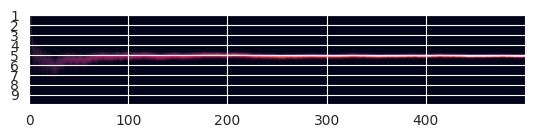

In [3]:
import os, sys
import numpy as np
from scipy.stats import gamma, uniform
from matplotlib import pyplot as plt

# Necessary to import local scripts that exist in separate directory below
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from foraging import utils
import utils.models

schedule_candidates = np.arange(1,10, 0.1)
prior = uniform.pdf(schedule_candidates, loc = schedule_candidates.min(), scale =schedule_candidates.max() - schedule_candidates.min())
normal = utils.models.MyNormalizer()
prior = normal.normalize(prior)

# construct likelihood/observation model
shape = 10
obs_model = utils.models.GammaObservation(shape)
n_times = 500
true_rate = 5
posterior = utils.models.MyPosterior(obs_model, prior, schedule_candidates, normal)
probs = np.zeros((n_times, len(schedule_candidates)))
push_interval = true_rate
for i in range(n_times):
    rt = gamma.rvs(shape, scale = true_rate/shape)
    ro = push_interval >  rt # this assumes box resets every push
    probs[i] = posterior.update((ro, push_interval))
plt.imshow(probs[:,:].T, aspect='equal')
plt.yticks(range(0, len(schedule_candidates), 10), ['%d' % x for x in schedule_candidates[range(0, len(schedule_candidates), 10)]])

We verify by eye that the bayesian update is correct in the following simple setup of inferring the parameter of a Bernoulli random process. In this setup, starting with a uniform prior and always observing a success should result in a posterior where each probability is multiplied by its corresponding latent (also a probability) ie. after the nth update, the posterior probabilities should be proportionate to their corresponding latent to the nth power.

In [19]:
import numpy as np
from scipy.stats import bernoulli
from foraging import utils
import utils.models

class BinaryObservation(utils.models.Observation):
    def probability(self, obs, latent, **kwargs):
        return bernoulli.pmf(obs, latent)
    def support(self):
        return np.array([0, 1])
    def probabilities(self, latent, **kwargs):
        return bernoulli.pmf([self.support()], latent)

latents = np.linspace(0.2,1,4)
prior = np.ones(len(latents)) / len(latents)
print("prior", prior)
print("latents", latents)
obs_model = BinaryObservation()
normal = utils.models.MyNormalizer()
posterior = utils.models.MyPosterior(obs_model, prior, latents, normal)
n_checks = 3
for i in range(n_checks):
    posterior.update(1)
    print(posterior.probabilities())
    test = posterior.probabilities() / (latents ** (i + 1))
    np.testing.assert_almost_equal(test, test[0])

prior [0.25 0.25 0.25 0.25]
latents [0.2        0.46666667 0.73333333 1.        ]
[0.08333333 0.19444444 0.30555556 0.41666667]
[0.02227723 0.12128713 0.29950495 0.55693069]
[0.00531915 0.06757289 0.26221434 0.66489362]
